# Coding Challenge
## Image Median Filter Parallelization

### Description of the Challenge
Local median filter is used for smoothing images and noise reduction. The degree of smoothing is determined by the kernel size which can be 2D or 3D. Applying 3D median filter to large 3D images (eg. 2000x2000x2000 voxels) is challenging because the images often do not fit in the memory and single-threaded execution of the filter is inefficient and too slow.

## Task 1
### Assignment
Create a 3D synthetic image and split it into subvolumes and apply median filter (like `skimage.filters.median`) to each subvolume in parallel. The output needs to be a 3D array with the same size as the original 3D image.

### Solution

#### Generation of synthetic images
For this assignment I could have created a dataset that contains only random noise, but it helpful to see some sort of a structure to verify that the filter actually does smoothing in the intended way. I downloaded the standard [scikit-image `cells3d` dataset](https://gitlab.com/scikit-image/data/-/raw/master/cells3d.tif) and I am going to use it to create artificial datasets with different number of voxels (vx). They will be of several differnt sizes to run the benchmark tests.

In [1]:
# Imports
%pylab inline

from skimage.io import imread
from skimage.filters import median
from skimage.morphology import cube
from skimage.transform import rescale

import pandas as pd

import os
from time import time

# I'll use dask and napari later but importing everything in one place
from dask.distributed import Client
from dask.array.image import imread as imread_dask
from dask_image.ndfilters import median_filter as median_dask
import dask
import numpy as np
import napari
import zarr

Populating the interactive namespace from numpy and matplotlib


In [3]:
print(imread("cells3d.tif").shape)

(60, 2, 256, 256)


The order of the dataset axes is `ZSXY` where `S` are two spectral channels. I'm interested only in one of them.

In [4]:
def middle(stack):
    """ Extracts middle layer from an image stack. We assume Z axis is the fist one. """
    return stack[stack.shape[0]//2]

def middle_vert(stack):
    """ Extracts middle layer from an image stack in a vertical plane"""
    return stack[:, stack.shape[1]//2, :]

In [5]:
img = imread("cells3d.tif")[:, 1, :, :]

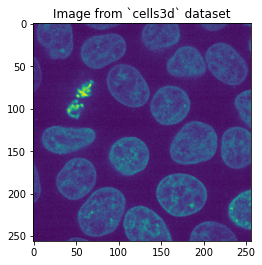

In [6]:
imshow(middle(img)); title("Image from `cells3d` dataset");

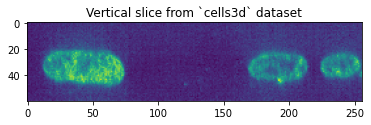

In [7]:
imshow(middle_vert(img)); title("Vertical slice from `cells3d` dataset");

Define benchmarking functions

In [8]:
def stopwatch(func):
    """ Benchmarking python decorator. Returns execution time, result, and name of the decorated function. """
    def wrapper(*arg, **kw):
        t1 = time()
        res = func(*arg, **kw) # we expect `res` to be a numpy array
        t2 = time()
        size = np.prod(res.shape) // 1_000  # image size in thousands of voxels
        return dict(name=func.__name__, time=(t2 - t1), size=size), res
    return wrapper

def plot_benchmark(benchmark_data, title="", xlabel="Image volume, kvx", ylabel="time, s", **kwargs):
    """ Plot and pretty print benchmarking data """
    df = pd.DataFrame.from_dict(benchmark_data)
    df.plot("size", "time", style='.-', title=title, xlabel=xlabel, ylabel=ylabel, **kwargs)
    return df

Define functions to generate data

In [9]:
def create_image(scale = 1, SNR = 10, readout_noise = 2):
    """
    Create an artificial dataset based on `cells3d` with given size and noise levels.
    The original image is either downscaled or is made bigger by padding it with it's own
    edge values to create signal in the areas around it. Then we create a simulated shot
    noise-limited image and add camera noise on top of it.
     
    Arguments
    ---------
    scale -- size of the new dataset relative to cells3d (about 4M voxels). Value of 2 means
             twice along each axis, or 8x more voxels. Value of 0.5 means downscale by factor 2
    SNR -- signal to noise ratio of the simulated image (shot noise model)
    readout_noise -- level of the simulated camera noise (Gaussian model)
    
    Returns
    -------
    3d numpy array
    """
    assert scale > 0
    src = imread("cells3d.tif")[:, 1, :, :]
    
    if scale < 1:
        img = rescale(src, scale)
    else:
        # Pad original image with its edge values
        z, x, y = src.shape
        pad = (
            int(0.5 * z * (scale - 1)),
            int(0.5 * x * (scale - 1)),
            int(0.5 * y * (scale - 1))
        )
        pad = [_ for _ in zip(pad, pad)]
        img = np.pad(src, pad, mode='edge')

    # Normalize image to [0,1] range
    img = (img - np.min(img))/np.ptp(img)
    
    # Create a simulated image with shot noise. SNR is sqrt(N), where N is the expected number of photons
    img = np.random.poisson(img * int(SNR**2))
    
    # Add camera bias and thermal noise and return the dataset
    return img + np.random.normal(loc=10, scale=readout_noise, size=img.shape).astype('int32')

@stopwatch
def save_dataset(scale, path="dataset", SNR=6):
    """ Create a new synthetic image and save it as Zarr. """
    d = create_image(scale=scale, SNR=SNR)
    zarr.save(f"{path}/{scale}.zarr", d)
    return d

Now we have code to generate synthetic datasets of arbitrary size and signal-to-noise ratio. Let's compare the original image to noisy ones and pick a good SNR to work with.

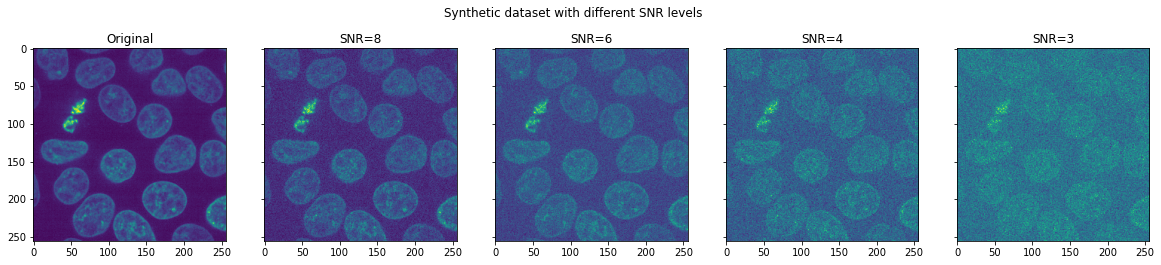

In [10]:
SNR_levels = [8, 6, 4, 3]
fig, axes = plt.subplots(1, len(SNR_levels) + 1, figsize = (20, 4), sharey = True)
fig.suptitle("Synthetic dataset with different SNR levels")
axes[0].imshow(middle(img))
axes[0].set_title("Original")
for i, SNR in enumerate(SNR_levels):
    axes[i+1].imshow(middle(create_image(scale=1, SNR=SNR)))
    axes[i+1].set_title(f"SNR={SNR}")

For all further tests I'm going to use `SNR = 6` as it is quite noisy but still has a clearly visible pattern.

Now let's generate datasets of different sizes and save them to Zarr for fast access.

In [11]:
# This code saves data only if the data are not present. This cell may take couple of minutes!
scales = [0.25, 0.5, 0.75, 1, 1.5, 2, 3]
SNR = 6

if not os.path.exists("dataset"):
    bm_create_save_data = []
    for i, scale in enumerate(scales):
        bm_create_save_data.append(save_dataset(scale, SNR=SNR)[0])

We can open any of this picture in napari like this:

```python
v = napari.Viewer()
v.add_image(zarr.open("dataset/3.zarr"))
```

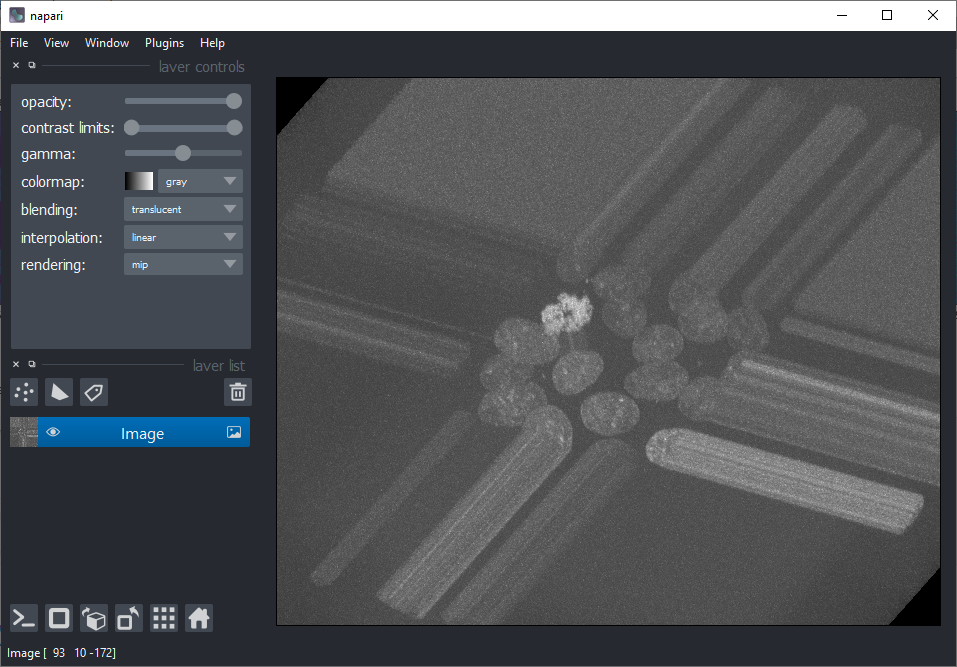

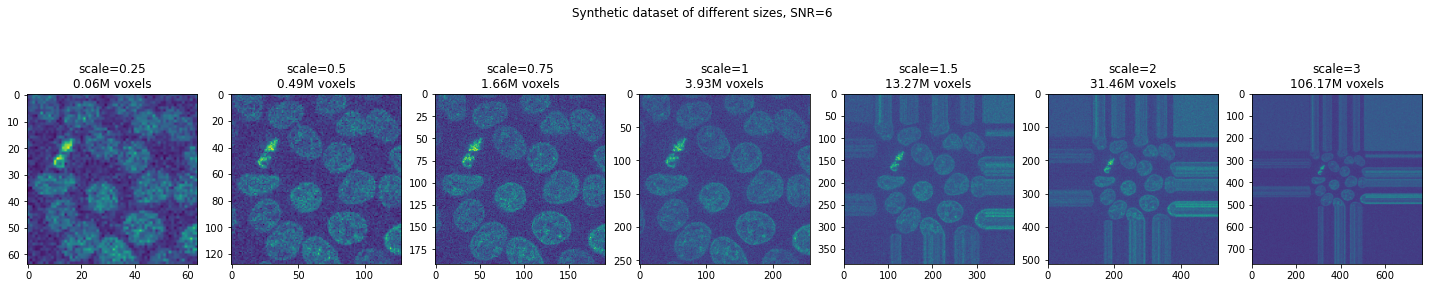

In [12]:
fig, axes = plt.subplots(1, len(scales), figsize = (25, 5))
fig.suptitle(f"Synthetic dataset of different sizes, SNR={SNR}")
for i, scale in enumerate(scales):
    d = zarr.load(f"dataset/{scale}.zarr")
    size = float(np.prod(d.shape) / 1e6)
    axes[i].imshow(middle(d))
    axes[i].set_title(f"scale={scale}\n{size:.2f}M voxels")

,name,time,size
0,save_dataset,0.135513,61
1,save_dataset,0.218270,491
2,save_dataset,0.429564,1658
3,save_dataset,0.489808,3932
4,save_dataset,1.376396,13271
5,save_dataset,2.985914,31457
6,save_dataset,9.551344,106168


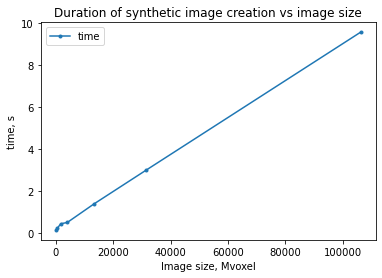

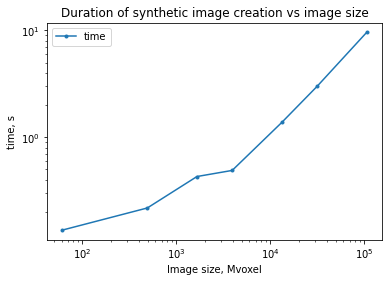

In [137]:
plot_benchmark(bm_create_save_data, title="Duration of synthetic image creation vs image volume")
plot_benchmark(bm_create_save_data, title="Duration of synthetic image creation vs image volume", loglog=True)

#### Image smoothing with 3D median filter

First of all, I'm going to directly apply a 3D median filter (`skimage.filters.median`) with cube-shaped kernel size of `3` to a synthetic dataset and visualize the result before and after smoothing.

In [14]:
img = zarr.load("dataset/1.5.zarr")
denoised = median(img, selem=cube(3))

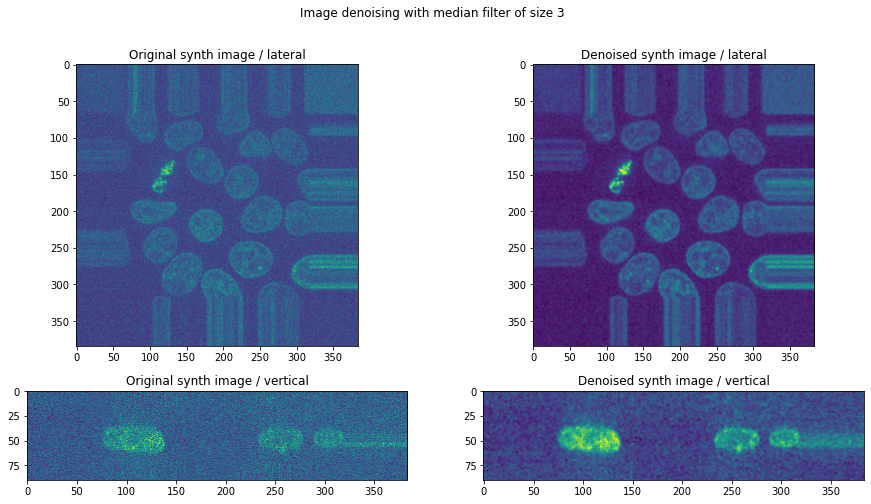

In [15]:
fig = plt.figure(figsize = (15, 8))
fig.suptitle("Image denoising with median filter of size 3")

ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 2), (2, 0))
ax3 = plt.subplot2grid((3, 2), (0, 1), rowspan=2)
ax4 = plt.subplot2grid((3, 2), (2, 1))

ax1.imshow(middle(img));
ax1.set_title("Original synth image / lateral");

ax2.imshow(middle_vert(img));
ax2.set_title("Original synth image / vertical");

ax3.imshow(middle(denoised));
ax3.set_title("Denoised synth image / lateral");

ax4.imshow(middle_vert(denoised));
ax4.set_title("Denoised synth image / vertical");

Now I'm going to measure how long it takes to process datasets of different sizes. **I expect to see a linear dependency between the data set size in voxels and processing time, i.e. linear time complexity _O(n)_**.

In [16]:
@stopwatch
def denoise(img, selem=cube(3)):
    """ Denoise image with a median filter """
    return median(img, selem=selem)

In [141]:
bm_denoise_imgsize = []
for scale in scales:
    img = zarr.load(f"dataset/{scale}.zarr")
    bm_denoise_imgsize.append(denoise(img)[0])

,name,time,size
0,denoise,0.015947,61
1,denoise,0.123586,491
2,denoise,0.417604,1658
3,denoise,0.989736,3932
4,denoise,3.334839,13271
5,denoise,8.052067,31457
6,denoise,28.268489,106168


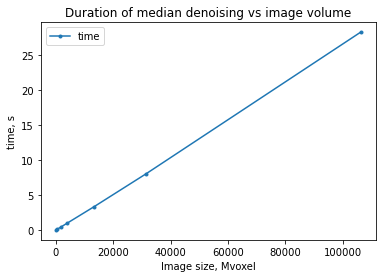

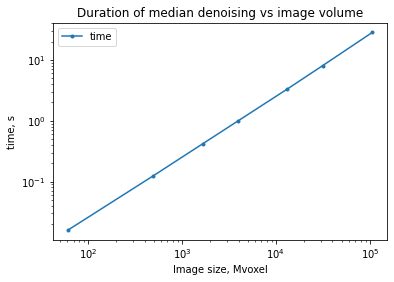

In [166]:
plot_benchmark(bm_denoise_imgsize, title="Duration of median denoising vs image volume")
plot_benchmark(bm_denoise_imgsize, title="Duration of median denoising vs image volume", loglog=True)

**As expected, we see perfect _O(n)_ linear dependency, where _n_ is the number of voxels in the image.**

Next, let's investigate how size of the convolution kernel affects peformance. Again, I suspect it is _O(n)_. I'm going to pick image of a fixed size and run kernels of different size on it.

In [164]:
img = zarr.load("dataset/0.25.zarr")

kernel_sizes = range(3, 30, 4)

bm_denoise_kernsize = []
for k in kernel_sizes:
    bm_denoise_kernsize.append(denoise(img, cube(k))[0])

,name,time,size,kernel
0,denoise,0.022874,61,3
1,denoise,0.139926,61,7
2,denoise,0.514894,61,11
3,denoise,1.334100,61,15
4,denoise,2.799247,61,19
5,denoise,5.239063,61,23
6,denoise,8.985086,61,27


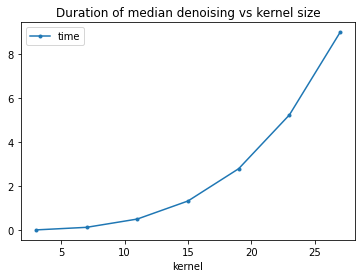

In [165]:
df = pd.DataFrame.from_dict(bm_denoise_kernsize)
df['kernel'] = kernel_sizes
df.plot("kernel", "time", style=".-", title="Duration of median denoising vs kernel size")
df

It doesn't seem to be linear, but wait! We are looking at the size of the 3D kernel (i.e. it's cross-section), not the volume. Therefore, the perceived complexity is _O(x^3)_, where _x_ is the kernel size. However, it still has to be linear with regard to the number of voxels in the kernel structural element. To prove this point, I'm plotting time vs kernel volume (size^3).

,name,time,size,kernel,voxels
0,denoise,0.022874,61,3,27
1,denoise,0.139926,61,7,343
2,denoise,0.514894,61,11,1331
3,denoise,1.334100,61,15,3375
4,denoise,2.799247,61,19,6859
5,denoise,5.239063,61,23,12167
6,denoise,8.985086,61,27,19683


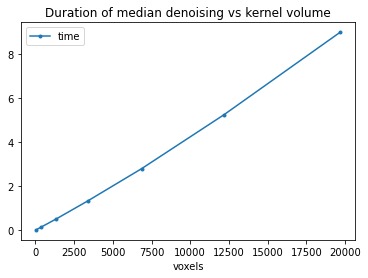

In [170]:
df = pd.DataFrame.from_dict(bm_denoise_kernsize)
df['kernel'] = kernel_sizes
df['voxels'] = df['kernel']**3
df.plot("voxels", "time", style=".-", title="Duration of median denoising vs kernel volume")
df

#### Parallelization of the median filter
I'm going to split image into chunks and use `multiprocessing` python module to run smoothing in parallel.

In [50]:
import multiprocessing
from multiprocessing import Process, Pipe

print("Number of cpu : ", multiprocessing.cpu_count())

Number of cpu :  8


In [47]:
img = zarr.load("dataset/1.zarr/")

# Split image stack into tiles (quick and dirty)
N, H, W = img.shape
M = int(H/2)  # tile size      
tiles = [img[:, y:y+M, x:x+M] for y in range(0, H, M) for x in range(0, W, M)]

# Allocate memory for destination tiles
smoothed_tiles = [tile for tile in tiles]

In [ ]:
def denoise(img, selem=cube(3)):
    """ Denoise image with a median filter """
    return median(img, selem=selem)

In [ ]:
# This cell never finishes, and I have trouble debugging it!
# ----------------------------------------------------------
procs = []

# I plan to assign a separate process for each tile and use multiprocessing.Pipe to exchange data
for i, tile in enumerate(tiles):
    proc = Process(target = denoise, args = (tiles,))
    procs.append((i, proc))
    proc.start()
    
# At this point I need to wait for all of the child processes to complete processing of their
# corresponding tiles and then send the result via Pipe back to the main process. In the main
# process, I'm going to put smoothed tiles together and reconstruct the big image.

Unfortunately, I struggled to make this work because the cell computation never finishes and I could not interrupt the kernel, which means I have to run the notebook from the very beginning. I also struggled passing numpy arrays over multiprocessing.Pipe - the `connection.send()` function also does not return. Looks like I don't know some important details about the `multiprocessing` module, and they are not obvious to me.

#### How this was supposed to work:
* **The original image is split into chunks (subvolumes) using `numpy` slicing.** We need to keep in mind, that the original `numpy` image must already be completely in the memory unless we use image provider that loads subvolumes on demand (such as a Zarr file or a database).
* **We create a pool of child processes each of which runs a denoising function and gets chunk(s) to process.**
* We **create Pipe(s) to send data from the parent process to the children, and receive processed data.** Every chunk sent over pipe must include a unique identifier.
* Once the parent process started all pipes and child processes, it has to **wait for the completion of child processes** by calling `child_process.join()`.
* After all child processes completed, the parent process takes data out of the Pipe(s), and **reconstructs the big image** using the identifiers of the subvolumes and the knowledge of the original tile coordinates.

This is a pretty complex system to implement and troubleshoot. I'm also afraid that after the reconstruction there might be visible artifacts (seams) along the borders of the subvolumes. This would happen because the median filter would lack data at the subvolume border. The workaround would be to split original image into overlapping subvolumes, as described in [dask documentation](https://docs.dask.org/en/stable/array-overlap.html).

## Task 2
### Assignment
Quantitatively compare the method you developed in Challenge 1 to existing methods like Dask-image or GPU-based parallelization like Cucim where applicable.

### Solution

I have experience working with `dask`, and I'm going to use it to smooth sythetic data in parallel.

In [33]:
dimg = dask.array.from_zarr("dataset/2.zarr/")
dimg

dask.array<from-zarr, shape=(120, 512, 512), dtype=int32, chunksize=(15, 128, 128), chunktype=numpy.ndarray>

In [34]:
dimg.rechunk(chunks=16)

,Array,Chunk
Bytes,120.00 MiB,16.00 kiB
Shape,"(120, 512, 512)","(16, 16, 16)"
Count,23681 Tasks,8192 Chunks
Type,int32,numpy.ndarray


Now I'm going to change the number of chunks in the dataset and see how it affects the computation performance. I use distributed dask client to monitor the process.
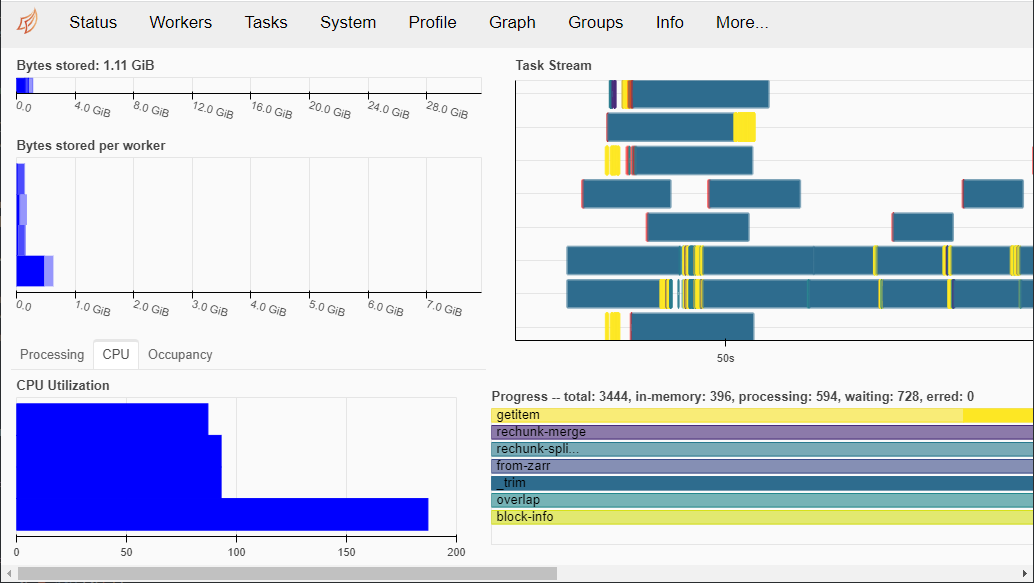

In [36]:
@stopwatch
def denoise_dask(img, size=3):
    """ Denoise image with a median filter using dask"""
    return median_dask(img, size=size).compute()

In [37]:
chunk_sizes = [512, 128, 32, 16]

bm_denoise_Nchunks = []
for chunk_size in chunk_sizes:
    dimg = dimg.rechunk(chunks=chunk_size)
    N = dimg.npartitions
    bm_denoise_Nchunks.append(dict(
        N = N,
        **(denoise_dask(dimg, 3)[0])
    ))

,N,name,time,size
0,1,denoise_dask,8.418269,31457
1,16,denoise_dask,3.247611,31457
2,1024,denoise_dask,44.976563,31457
3,8192,denoise_dask,406.186384,31457


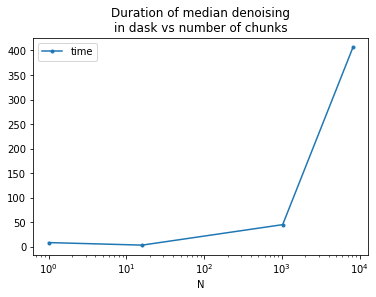

In [46]:
df = pd.DataFrame.from_dict(bm_denoise_Nchunks)
ax = df.plot("N", "time", style=".-", title="Duration of median denoising\nin dask vs number of chunks", logx=True)
df

We clearly see two interesting trends:
1) 16 chunks are being processed about 2.6 times faster than 1 chunk. This happens because my computer has 4× physical cores and with 16 chunks the denoising is parallelized.
2) We cannot get 4× boost in performance with 4× cores because there is an overhead associated with managing chunks.
1) That there is a huge drop in performance as the number of chunks grows big. This happens because handling of each chunk is associated with an extra overhead.

### Conclusions

It's important to note that Python has a global interpreter lock and thus true parallel processing can be achieved only by starting parallel processes (quite expensive!) and not threads. For maximum performance, the number of processes should be close to the number of virtual cores (hyperthreading) of the computing system. Low number of threads would mean unused cores, and high number of threads would mean more overhead (memory and CPU cache) switching between processes.

The benchmarks presented here might not be representative for all situations for a number of reasons:
* I ran them only once, so it's hard to estimate the variance from run to run. Ideally, one should run benchmarsk several times to get more accurate results and have and an idea of variances between executions. 
* The number of conditions in my benchmarks is rather low. However, running more tests costs a lot of time.
* The datasets analyzed here are small enough to fit into the memory of my computer (32Gb). In real applications this is often not the case. Lack of memory might lead to  huge performance delays when virtual memory (swap space on a hard drive) is being used, or to a crash of the application.
